In [3]:
# requirements

from itertools import chain
import nltk
import sklearn
import scipy
import pandas as pd
import numpy as np

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

np.random.seed(314)


In [4]:
# setting up all the files folders
# while running the code please check if the file names are correct as there is " " in the test file before ".conllu"
train_path = 'hi-ud-train.conllu'
test_path = 'hi-ud-test .conllu'

In [5]:
# helper function to get the data
def get_data(path, split_by = ','):
    corpora = open(path, "r", encoding="utf-8").readlines()
    sents = []
    words = []
    for raw_line in corpora[1:]:
        line = raw_line.strip('\n').split(split_by)
        if line == ['', '', '']:
            sents.append(words)
            words = []
        else:
            words.append(line)
    return sents

# getting the data
train_sents = get_data(train_path, ',')
test_sents  = get_data(test_path, '\t')

In [6]:
train_sents[0:2]
test_sents[0:2]

[[['1', 'rAmAyaNa', 'PROPN'],
  ['2', 'kAla', 'PROPN'],
  ['3', 'meM', 'ADP'],
  ['4', 'BagavAna', 'NOUN'],
  ['5', 'rAma', 'PROPN'],
  ['6', 'ke', 'ADP'],
  ['7', 'puwra', 'NOUN'],
  ['8', 'kuSa', 'PROPN'],
  ['9', 'kI', 'ADP'],
  ['10', 'rAjaXAnI', 'NOUN'],
  ['11', 'kuSAvawI', 'PROPN'],
  ['12', 'ko', 'ADP'],
  ['13', '483', 'PROPN'],
  ['14', 'IsA', 'PROPN'],
  ['15', 'pUrva', 'PROPN'],
  ['16', 'buxXa', 'PROPN'],
  ['17', 'ne', 'ADP'],
  ['18', 'apane', 'PRON'],
  ['19', 'aMwima', 'ADJ'],
  ['20', 'viSrAma', 'NOUN'],
  ['21', 'ke', 'ADP'],
  ['22', 'lie', 'ADP'],
  ['23', 'cunA', 'VERB'],
  ['24', '.', 'PUNCT']],
 [['1', 'malloM', 'NOUN'],
  ['2', 'kI', 'ADP'],
  ['3', 'rAjaXAnI', 'NOUN'],
  ['4', 'hone', 'VERB'],
  ['5', 'ke', 'ADP'],
  ['6', 'kAraNa', 'ADP'],
  ['7', 'prAcInakAla', 'NOUN'],
  ['8', 'meM', 'ADP'],
  ['9', 'isa', 'DET'],
  ['10', 'sWAna', 'NOUN'],
  ['11', 'kA', 'ADP'],
  ['12', 'awyaMwa', 'ADJ'],
  ['13', 'mahawva', 'NOUN'],
  ['14', 'WA', 'VERB'],
  ['15', '.', 

### Features used

|number| feature | details |
|---|-------|-------|
|1| bias | 1 for all words |
|2|index | location at which this word comes in the sentence |
|3| caps_freq | number of times a capital letter is there is the word divide by the length of word |
|4|word.lower() | word converted to lower case |
|5|word\[-3:\] | 3 letter suffix of the word |
|6|word\[-2:\] | 2 letter suffix of the word |
|7|word\[-1:\] | 1 letter suffix of the word |
|8|word\[:1\] | 1 letter prefix of the word |
|9|word\[:2\] | 2 letter prefix of the word |
|10|word\[:3\] | 3 letter prefix of the word |
|11|word.isupper() | 1 if all letters are upper case else 0 |
|12|word.istitle() | 1 only if 1st letter is upper and all else lower if not then 0 |
|13|word.isdigit() | 1 if it is a digit else 0 |
|14|word.length | length of the word |
|15|BOS| 1 if its start of the sentence |
|16|EOS| 1 if its end of the sentence |

note : for each word we also look at the last and next word of it and also the features 3,11,12,13 and 14 for those words

In [7]:
def caps_freq(word):
    """
    this feature is basically gives (number of upper case letter)/(number of upper case letter + number of lower case letter)
    """
    count = 0.0
    for s in word:
        if s.isupper():
            count+=1    
    count/=max(1.0,len(word))
    return count
            

# function to generate the features
def word2features(sent, i):
    index = sent[i][0]
    word = sent[i][1]
    postag = sent[i][2]

    features = {
        'bias': 1.0,
        'index': index,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-1:]': word[-1:],
        'word[:3]': word[:3],
        'word[:2]': word[:2],
        'word[:1]': word[:1],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word.length': len(word),
        'caps_freq': float(caps_freq(word))
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.length': len(word1),
            '-1:caps_freq': float(caps_freq(word1))
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word.length': len(word1),
            '+1:caps_freq': float(caps_freq(word1))
        })
    else:
        features['EOS'] = True

    return features

# Sentence Feature Extraction
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for index, token, postag in sent]

def sent2tokens(sent):
    return [token for index, token, postag in sent]

In [8]:
# raw data columns to data with feature

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [9]:
# one small example for a sentence

pd.DataFrame(X_train[44])

,bias,index,word.lower(),word[-3:],word[-2:],word[-1:],word[:3],word[:2],word[:1],word.isupper(),...,+1:word.istitle(),+1:word.isupper(),+1:word.length,+1:caps_freq,-1:word.lower(),-1:word.istitle(),-1:word.isupper(),-1:word.length,-1:caps_freq,EOS
0,1.0,1,varra,rRa,Ra,a,var,va,v,False,...,False,False,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,mem,meM,eM,M,meM,me,m,False,...,False,False,1.0,0.0,1,False,False,1.0,0.0,NaN
2,1.0,3,kabi,aBI,BI,I,kaB,ka,k,False,...,False,False,1.0,0.0,2,False,False,1.0,0.0,NaN
3,1.0,4,bi,BI,BI,I,BI,BI,B,True,...,False,False,1.0,0.0,3,False,False,1.0,0.0,NaN
4,1.0,5,apa,Apa,pa,a,Apa,Ap,A,False,...,False,False,1.0,0.0,4,False,False,1.0,0.0,NaN
5,1.0,6,yahaz,hAz,Az,z,yah,ya,y,False,...,False,False,1.0,0.0,5,False,False,1.0,0.0,NaN
6,1.0,7,ja,jA,jA,A,jA,jA,j,False,...,False,False,1.0,0.0,6,False,False,1.0,0.0,NaN
7,1.0,8,sakawe,awe,we,e,sak,sa,s,False,...,False,False,1.0,0.0,7,False,False,1.0,0.0,NaN
8,1.0,9,hem,hEM,EM,M,hEM,hE,h,False,...,False,False,2.0,0.0,8,False,False,1.0,0.0,NaN
9,1.0,10,.,.,.,.,.,.,.,False,...,NaN,NaN,NaN,NaN,9,False,False,1.0,0.0,True


In [11]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [12]:
# labels list

labels = list(crf.classes_)
print(labels)
len(labels)

['DET', 'PROPN', 'ADP', 'ADV', 'ADJ', 'NOUN', 'NUM', 'AUX', 'PUNCT', 'PRON', 'VERB', 'CCONJ', 'PART', 'COMMA', 'SCONJ', 'X']


16

In [14]:
# predictions and results

y_pred = crf.predict(X_test)
f1 = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)
acc = metrics.flat_accuracy_score(y_test, y_pred)

print("Accuracy = {}\nF1 score = {}".format(acc, f1))

Accuracy = 0.8455678670360111
F1 score = 0.8434122090879953


In [16]:
# classification report

sorted_labels = sorted(labels,key=lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           X      0.000     0.000     0.000         0
        PART      0.971     1.000     0.985        33
       CCONJ      1.000     1.000     1.000        25
       SCONJ      0.667     0.667     0.667         3
         ADJ      0.691     0.713     0.702        94
         ADP      0.964     0.974     0.969       303
         ADV      0.600     0.429     0.500        21
        VERB      0.838     0.838     0.838        99
         DET      0.842     0.889     0.865        36
       COMMA      0.000     0.000     0.000         0
        NOUN      0.773     0.861     0.815       324
        PRON      0.918     0.862     0.889        65
       PROPN      0.615     0.521     0.564       144
         NUM      0.808     0.840     0.824        25
       PUNCT      1.000     0.836     0.911       134
         AUX      0.910     0.957     0.933       138

   micro avg      0.846     0.846     0.846      1444
   macro avg      0.725   

In [17]:
# hyperparameter tuning using random search

crf = sklearn_crfsuite.CRF(algorithm='lbfgs',max_iterations=100,all_possible_transitions=True)
params_space = {'c1': scipy.stats.expon(scale=0.02),'c2': scipy.stats.expon(scale=0.08)}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000236CBD3A2C8>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000236C9F86388>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['DET', 'PROPN', 'ADP', 'ADV', 'ADJ', 'NOUN', 'NUM', 'AUX', 'PUNCT', 'PRON', 'VERB', 'CCONJ', 'PART', 'COMMA', 'SCONJ', 'X']),
                   verbose=1)

In [18]:
# best model params

print('best params:', rs.best_params_)
print('best score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.018844240892569124, 'c2': 0.1616268898234428}
best score: 0.838804689090655
model size: 0.42M


Dark blue => 0.8271, dark red => 0.8388


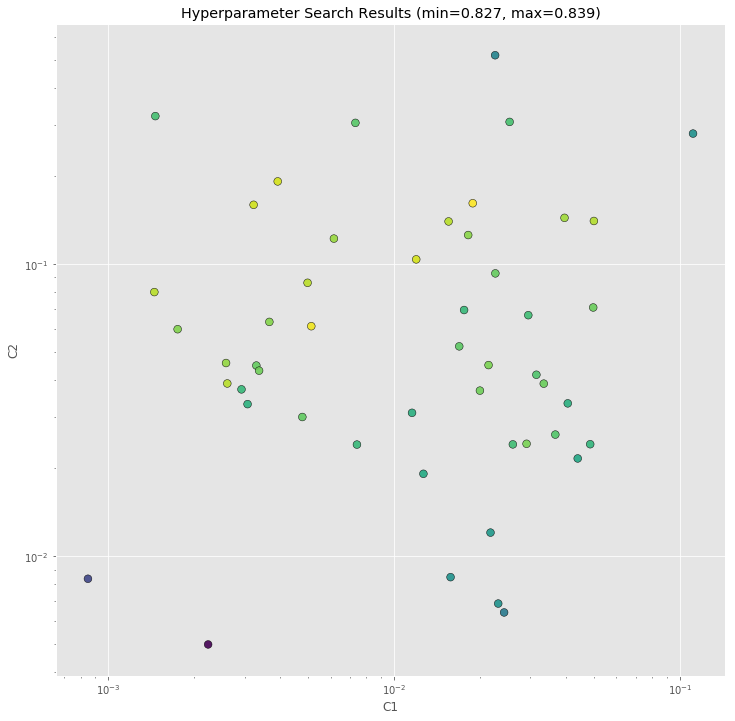

In [19]:
_x = rs.cv_results_["param_c1"]
_y = rs.cv_results_["param_c2"]
_c = rs.cv_results_["mean_test_score"]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Hyperparameter Search Results (min={:0.3}, max={:0.3})".format(min(_c), max(_c)))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [20]:
rs.cv_results_

{'mean_fit_time': array([1.25804186, 1.25514015, 1.10084685, 1.02685952, 1.04255438,
        1.02377931, 1.00584634, 1.02522516, 1.11897945, 1.16176653,
        1.10978953, 1.16536808, 1.07387678, 1.1310846 , 1.07171893,
        1.15013337, 1.05117321, 1.0854191 , 1.07940833, 1.0876569 ,
        1.11355035, 1.01445047, 1.04823534, 1.00484705, 1.00934974,
        1.00721018, 0.98636484, 1.03465565, 1.02620594, 1.0943048 ,
        1.18812585, 1.25083073, 1.02938445, 1.08154607, 1.10709063,
        1.17022427, 1.06617061, 1.21102389, 1.20192838, 1.11675533,
        1.25597095, 1.0898749 , 1.10511295, 1.13852223, 1.15936454,
        1.07763465, 1.15484126, 1.14160744, 1.19667466, 1.03403441]),
 'std_fit_time': array([0.03777472, 0.11571799, 0.03187825, 0.04068308, 0.03249509,
        0.03603922, 0.0366105 , 0.0248588 , 0.11039752, 0.02262968,
        0.04139802, 0.02781395, 0.02393889, 0.0721906 , 0.02262826,
        0.07898963, 0.01337561, 0.04160274, 0.05353925, 0.00725894,
        0.025

In [21]:
# get the best model and its predictions

crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           X      0.000     0.000     0.000         0
        PART      0.971     1.000     0.985        33
       CCONJ      1.000     1.000     1.000        25
       SCONJ      0.667     0.667     0.667         3
         ADJ      0.704     0.734     0.719        94
         ADP      0.967     0.974     0.970       303
         ADV      0.600     0.429     0.500        21
        VERB      0.866     0.848     0.857        99
         DET      0.800     0.889     0.842        36
       COMMA      0.000     0.000     0.000         0
        NOUN      0.773     0.864     0.816       324
        PRON      0.917     0.846     0.880        65
       PROPN      0.633     0.528     0.576       144
         NUM      0.815     0.880     0.846        25
       PUNCT      1.000     0.836     0.911       134
         AUX      0.911     0.964     0.937       138

   micro avg      0.850     0.850     0.850      1444
   macro avg      0.726   

In [22]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top 10 most likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))

print("\nTop 10 least likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top 10 most likely transitions:
VERB   -> AUX     3.225284
AUX    -> AUX     2.223406
DET    -> NOUN    2.041918
PART   -> NUM     2.013738
PROPN  -> PROPN   1.896575
NUM    -> NOUN    1.852065
ADJ    -> NOUN    1.652541
DET    -> PART    1.529679
ADP    -> ADP     1.490440
COMMA  -> CCONJ   1.484503

Top 10 least likely transitions:
DET    -> PROPN   -1.498124
PROPN  -> ADJ     -1.529382
ADP    -> COMMA   -1.708934
CCONJ  -> AUX     -1.785534
PROPN  -> DET     -1.873113
ADV    -> AUX     -1.929062
PROPN  -> AUX     -2.094518
DET    -> ADP     -2.101813
ADJ    -> PRON    -2.559492
ADJ    -> ADP     -2.958521


In [23]:
# final report on Train Data

y_pred = crf.predict(X_train)
sorted_labels = sorted(labels,key=lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(y_train, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           X      1.000     1.000     1.000         2
        PART      0.994     1.000     0.997       163
       CCONJ      0.987     1.000     0.993       150
       SCONJ      0.984     1.000     0.992        61
         ADJ      0.982     0.979     0.981       569
         ADP      0.983     0.992     0.987      1384
         ADV      0.890     0.882     0.886       110
        VERB      0.990     0.956     0.973       639
         DET      0.937     0.974     0.955       230
       COMMA      1.000     1.000     1.000       114
        NOUN      0.980     0.984     0.982      1596
        PRON      0.988     0.958     0.973       430
       PROPN      0.987     0.967     0.977       707
         NUM      0.980     0.987     0.984       152
       PUNCT      1.000     1.000     1.000       563
         AUX      0.971     0.996     0.983       728

    accuracy                          0.981      7598
   macro avg      0.978   

In [24]:
acc = metrics.flat_accuracy_score(y_train, y_pred)
print("Accuracy Train = {}".format(acc))

Accuracy Train = 0.9813108712819163


In [25]:
# final report on Test Data

y_pred = crf.predict(X_test)
sorted_labels = sorted(labels,key=lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

           X      0.000     0.000     0.000         0
        PART      0.971     1.000     0.985        33
       CCONJ      1.000     1.000     1.000        25
       SCONJ      0.667     0.667     0.667         3
         ADJ      0.704     0.734     0.719        94
         ADP      0.967     0.974     0.970       303
         ADV      0.600     0.429     0.500        21
        VERB      0.866     0.848     0.857        99
         DET      0.800     0.889     0.842        36
       COMMA      0.000     0.000     0.000         0
        NOUN      0.773     0.864     0.816       324
        PRON      0.917     0.846     0.880        65
       PROPN      0.633     0.528     0.576       144
         NUM      0.815     0.880     0.846        25
       PUNCT      1.000     0.836     0.911       134
         AUX      0.911     0.964     0.937       138

   micro avg      0.850     0.850     0.850      1444
   macro avg      0.726   

In [26]:
acc = metrics.flat_accuracy_score(y_test, y_pred)
print("Accuracy Test = {}".format(acc))

Accuracy Test = 0.8497229916897507
